In [1]:
import numpy as np
import xtrack as xt

env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')
env.call('../002_design_optics/matching_constraints.py')

line = -env['ccs_yr']

tt0 = line.get_table(attr=True)
tt0_quad = tt0.rows[tt0.element_type == 'Quadrupole']
tt0_sext = tt0.rows[tt0.element_type == 'Sextupole']

kq = {}
kq['triplet'] = ['kqd0ar', 'kqd0br', 'kqf1ar']
kq['section_a'] = ['kqd01r', 'kqf02r', 'kqd02r']
kq['section_b'] = ['kqd04r', 'kqf05r', 'kqd06r']
kq['yquads'] = ['kqy01r', 'kqy02r', 'kqy03r', 'kqy04r']

# Build vary objects keeping the initial signs
vary_kq = {}
for kk in kq.keys():
    vary_kq[kk] = []
    for nn in kq[kk]:
        vv = env[nn]
        vary_kq[kk].append(xt.Vary(nn, step=1e-8, tag=kk)) # Note the small step
vary_all = []
for kk in kq.keys():
    vary_all += vary_kq[kk]

tar_sdm1r = xt.TargetSet(at='sdm1r::0',
                betx=xt.LessThan(12.), bety=xt.LessThan(3.),
                alfx=xt.GreaterThan(0), alfy=0.13)
tar_sfy1r = xt.TargetSet(at='sdy1r::1',
                bety=8114.3, betx=xt.LessThan(100.),
                alfy=0., dx=xt.GreaterThan(0.3),
                muy=0.75+env['dmuy_sdy1r'])
tar_ipimag2 = xt.TargetSet(at='ipimag2',
                betx=42.8, alfx=0., alfy=0.1,
                dx=0.44, dpx=env['dpx_ccyr'])
tar_rmat_sext = xt.TargetRmatrix(start='sdy1r::1', end='sdy2r::1',
                r12=env['r12_ccsyr'], r34=env['r34_ccsyr'],
                r33=-1.0, r43=0.0, tol=1e-6, tag='rmat_sext')

# Initialize quads with a small strength
for vv in vary_all:
    nn = vv.name
    if env.vars.vary_default[nn]['limits'][1] > 1e-3:
        env[nn] = 1e-3
    else:
        env[nn] = -1e-3

# wipe sextupoles
for kk in ['ksdy1r', 'ksdy2r', 'ksdm1r', 'ksdm1r', 'ksfm2r',
           'ksfx1r', 'kcrabr']:
    env[kk] = 0.

opt_triplet = line.match(
    name='triplet',
    solve=False,
    betx=env['bxip'],
    bety=env['byip'],
    targets=[
        xt.TargetSet(bety=xt.LessThan(8400), at='qd0br'),

        xt.TargetSet(bety=xt.LessThan(3100), at='qf1br'), # This quad is off!
        xt.TargetSet(bety=xt.GreaterThan(3000), at='qf1br'),
        # End of final focus

        xt.TargetSet(betx=xt.GreaterThan(750), at='qd1r'),
        xt.TargetSet(betx=xt.LessThan(800), at='qd1r'),
        xt.TargetSet(bety=xt.LessThan(2200), at='qd1r'),
        xt.TargetSet(bety=xt.GreaterThan(2000), at='qd1r'),
    ],
    vary = vary_kq['triplet']
)
opt = opt_triplet
opt.step(100)

opt_imag1 = opt_triplet.clone(
    name='imag1', remove_targets=True, remove_vary=True,
    add_targets=[tar_sdm1r],  add_vary=vary_kq['section_a'])
opt_imag1.step(100)

opt_dsdy1r = opt_imag1.clone(
    name='sdy1r', remove_targets=True, remove_vary=True,
    add_targets=[tar_sfy1r], add_vary=vary_kq['section_b'])
opt_dsdy1r.step(100)

# Match r matrix s1/s2
opt_rsext = line.match(
    name='rmat_sext',
    solve=False,
    start='sdy1r::1', end='sdy2r::1', init_at='ipimag2',
    betx=135, bety=10, # Rough estimate
    targets=tar_rmat_sext, vary=vary_kq['yquads'])
opt = opt_rsext
opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)


# Refine optics at first sextupole using sections a and b (no other target)
opt_dsdy1r_refine = opt_dsdy1r.clone(name='dsdy1r_refine',
                                     add_vary=vary_kq['section_a'])
opt = opt_dsdy1r_refine
opt.step(100)

opt_imag2_with_qy = opt_dsdy1r.clone(
    name='imag2_with_qy',
    add_vary=vary_kq['section_a'] + vary_kq['yquads'],
    add_targets=[tar_ipimag2, tar_sdm1r, tar_rmat_sext])
opt = opt_imag2_with_qy
opt.step(100)

# Refine rmatrix
opt.disable(target=True, vary=True)
opt.enable(target='rmat_sext', vary='yquads')
opt.step(100)
opt.enable(target=True, vary=True)

# Refine the phase at sdy1r
opt.disable(target=True, vary=True)
opt.enable(target='sdy1r.*', vary=['section_b'])
opt.step(100)
opt.enable(target=True, vary=True)

# Full optimizer
opt_full = opt_imag2_with_qy.clone(name='full',
                        add_targets=opt_triplet.targets,
                        add_vary=opt_triplet.vary)
opt = opt_full
opt_full.enable(target=True, vary=True)

opt.targets[3].weight = 1000
opt.targets[9].weight = 1000
opt.step(100)

# To get the fine digits
opt.run_simplex(10000)

                                             
Optimize [triplet] - start penalty: 1.005e+06                         
Matching: model call n. 43 penalty = 0.0000e+00              
Optimize [triplet] - end penalty:     0                            
                                             
Optimize [imag1] - start penalty: 15.47                         
Matching: model call n. 22 penalty = 6.5736e-09              
Optimize [imag1] - end penalty:  6.57361e-09                            
                                             
Optimize [sdy1r] - start penalty: 5248                         
Matching: model call n. 756 penalty = 2.6444e-01              
Optimize [sdy1r] - end penalty:  0.264442                            
                                             
Optimize [rmat_sext] - start penalty: 251.2                         
Matching: model call n. 37 penalty = 1.2067e-06              
Optimize [rmat_sext] - end penalty:  1.20671e-06                            
          

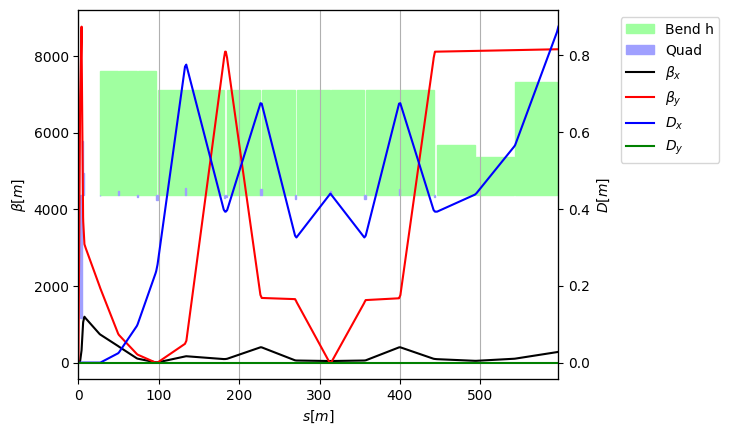

In [2]:
opt.plot()

In [3]:
strengths = opt_full.get_knob_values(-1)
xt.json.dump(strengths, 'strengths_quads_03_ffccsyr.json')